# Queue Imbalance as a One-Tick-Ahead Price Predictor in LOB


Order of this notebook is as follows:
1. [Data](#Data)
2. [Methodology](#Methodology)
3. [Results](#Results)
4. [Conclusions](#Conclusions)
5. [Other data](#Other-data)

Goal is to implement queue imbalance predictor from [[1]](#Resources).

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns

import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks from 2013-09 - 2013-11. The market is open between 8-16 on weekdays, so we use the data from 9-15 to avoid having data affected by the abnormal trading behaviour, which usually occurs right after opening or closing auction. The tick size is $\pi = 0.01$ for the market, but the *relative tick size*(the ratio between stock price and $\pi$) for each stock differs.

To each stock data we introduce:

* bid price: $$ b(t) := \underset{\{x \in bidList(t) \}}{\max} x.price $$
* ask price: $$ a(t) := \underset{\{x \in askList(t)\}}{\min} x.price $$

* total size of active buy orders: $$ n^{b}(p, t) = \sum_{\{x \in buyList(t), p_x = p\}} x.volumen $$

* total size of active sell orders: $$ n^{a}(p, t) = \sum_{\{x \in askList(t), p_x = p\}} x.volumen $$


* mid price: $$ m(t) := \frac{a(t) + b(t)}{2} $$

* queue imbalance: $$ I(t) := \frac{n^b (b_t , t) - n^a (a_t, t)}{n^b (b_t , t) + n^a (a_t, t)} $$ where $a_t$ and $b_t$ are ask and bid prices for time $t$ respectively.

* mid price indicator: $$ y_i = \begin{cases} 1 & \text{if} & m(t_i) > m(t_{i-1})\\ 0 & \text{if} & m(t_i) < m(t_{i-1})\\ \end{cases} $$

Based on the **queue imbalance** we will try to predict **mid price indicator**

In [2]:
from roc_results import results #results_even_data as results

df_roc = pd.DataFrame()
df_roc['stock'] = results.keys()
df_roc['roc_area'] = results.values()

df_roc = df_roc.sort_values(by='roc_area', ascending=False)

dfs = {}
dfs_test = {}

stocks = df_roc['stock'].values

for s in stocks:
    d, d_test = lob.load_prepared_data(s, length=None)
    dfs[s] = d
    dfs_test[s] = d_test

Len of data for  2028 is 6279
Training set length for 2028: 5024
Testing set length for 2028: 1255
Len of data for  2197 is 7286
Training set length for 2197: 5829
Testing set length for 2197: 1457
Len of data for  12098 is 5986
Training set length for 12098: 4789
Testing set length for 12098: 1197
Len of data for  12552 is 9049
Training set length for 12552: 7240
Testing set length for 12552: 1809
Len of data for  1221 is 6355
Training set length for 1221: 5084
Testing set length for 1221: 1271
Len of data for  10795 is 7492
Training set length for 10795: 5994
Testing set length for 10795: 1498
Len of data for  2748 is 5489
Training set length for 2748: 4392
Testing set length for 2748: 1097
Len of data for  4154 is 5737
Training set length for 4154: 4590
Testing set length for 4154: 1147
Len of data for  3459 is 7639
Training set length for 3459: 6112
Testing set length for 3459: 1527
Len of data for  3757 is 7298
Training set length for 3757: 5839
Testing set length for 3757: 1459
L

Len of data for  9069 is 17080
Training set length for 9069: 13664
Testing set length for 9069: 3416
Len of data for  1907 is 10499
Training set length for 1907: 8400
Testing set length for 1907: 2099
Len of data for  9061 is 17245
Training set length for 9061: 13796
Testing set length for 9061: 3449
Len of data for  5836 is 10892
Training set length for 5836: 8714
Testing set length for 5836: 2178
Len of data for  9265 is 15986
Training set length for 9265: 12789
Testing set length for 9265: 3197
Len of data for  9269 is 15689
Training set length for 9269: 12552
Testing set length for 9269: 3137
Len of data for  10484 is 10693
Training set length for 10484: 8555
Testing set length for 10484: 2138
Len of data for  9064 is 17676
Training set length for 9064: 14141
Testing set length for 9064: 3535
Len of data for  11867 is 14269
Training set length for 11867: 11416
Testing set length for 11867: 2853
Len of data for  11244 is 17518
Training set length for 11244: 14015
Testing set length 

In [3]:
stocks = [s for s in stocks if len(dfs[s]) > 8000]
print(len(stocks))

53


In [4]:
df_roc = pd.DataFrame()
df_roc['stock'] = [s for s in results.keys() if s in stocks]
df_roc['roc_area'] = [results[s] for s in results.keys() if s in stocks]
df_roc = df_roc.sort_values(by='roc_area', ascending=False)
df_roc.head()

,stock,roc_area
25,3035,0.583822
50,11946,0.582509
47,8080,0.582078
12,1956,0.581724
40,3879,0.578833
9,12456,0.576584
33,9268,0.575718
28,4799,0.574800
43,12417,0.574494
45,4320,0.573487


### Description of DataFrame

The data is indexed with time $t$.

* `bid` - bid queue
* `ask` - ask queue
* `bid_price` - bid price $b(t)$
* `ask_price` - ask price $a(t)$
* `mid_price` - mid price $m(t)$
* `sum_sell_ask` - total size of active sell orders for ask price  $ n^{a}(a(t), t) $
* `sum_buy_bid` - total size of active buy orders for bid price  $ n^{b}(b(t), t) $
* `mid_price_indicator` - the indicator if the mid price will rise in the **next** time tick
* `queue_imbalance` - $I(t)$

### Stock characteristic

For each stock we want to know how the can compare the *relative tick size* as the authors of [[1]](#Resources) saw it's is relevant for predictions. They decided that stocks are: 

* *large-tick stocks* when **maximal trade price** was below $50.00$
* *small-tick stocks* when **minimal trade price** was above $100.00$

They found out that the stocks which were between these two tresholds could behave similarily to both of these groups. 
    
The means of $n^{b}(b(t), t)$ and $n^{a}(a(t), t)$ for:

* *large-tick* stocks were above 3000 
* *small-tick* stocks were below 200

The bid ask spread for:

* *large-tick* stocks was below 0.02
* *small-tick* stocks was above 0.2

In [5]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []
pearson_corrs1 = []
pearson_corrs2 = []
bid_len = []
ask_len = []
from scipy.stats import pearsonr
for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())
    p1, p2 = pearsonr(dfs[s]['queue_imbalance'], dfs[s]['mid_price'])
    pearson_corrs1.append(p1)
    pearson_corrs2.append(p2)
    max_len_bid = 0
    max_len_ask = 0
    for i, row in dfs[s].iterrows():
        if len(row['bid']) > max_len_bid:
            max_len_bid = len(row['bid'])
        if len(row['ask']) > max_len_ask:
            max_len_ask = len(row['ask'])

    bid_len.append(max_len_bid)
    ask_len.append(max_len_ask)
df_summary['roc_area'] = df_roc['roc_area'].values
df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['diff_mean_bid_ask'] = df_summary['sum_sell_ask_mean'] - df_summary['sum_buy_bid_mean']
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['diff_trade_price'] = df_summary['max_trade_price'] - df_summary['min_trade_price']
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary['pearson_corr1'] = pearson_corrs1
df_summary['pearson_corr2'] = pearson_corrs2
df_summary['len_ask'] = ask_len
df_summary['len_bid'] = bid_len

df_summary.sort_values(by='bid_ask_spread')[df_summary['roc_area'] >= 0.58]


,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid
1956,0.581724,7641.837035,8492.734066,-850.897030,306.4,264.8,41.6,0.153452,0.091559,6.845194e-17,1070,846
11946,0.582509,17693.761818,17930.643211,-236.881393,206.1,183.6,22.5,0.170185,0.048886,8.671961e-06,939,812
3035,0.583822,6350.159385,5920.926133,429.233252,263.7,235.9,27.8,0.191565,0.044378,3.908516e-05,810,717
8080,0.582078,534.510166,529.277823,5.232342,3547.0,3128.0,419.0,2.009637,-0.009008,4.060686e-01,902,740


In [6]:
df_summary.sort_values(by='roc_area')

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid
9062,0.523169,941.166085,958.608717,-17.442632,3405.00,2937.00,468.00,1.020939,0.011009,1.921049e-01,2517,2708
4618,0.528495,699.707931,690.117899,9.590032,4955.00,4233.00,722.00,1.875670,0.028672,2.412294e-03,1276,1449
9074,0.537360,3957.187347,3740.050175,217.137173,2240.50,1977.00,263.50,0.680803,-0.026772,4.154976e-03,1208,1085
12059,0.539304,5761.327774,5527.666506,233.661268,391.30,317.20,74.10,0.220570,0.043550,1.213154e-06,2166,2032
9086,0.540619,41718.408675,42268.554239,-550.145564,244.20,208.10,36.10,0.064098,-0.029164,2.084410e-03,2050,2704
9063,0.541335,8143.136539,7618.765707,524.370832,510.10,427.05,83.05,0.093358,0.009434,2.779439e-01,3101,2972
11244,0.542006,4195.989583,4241.678131,-45.688548,355.50,321.70,33.80,0.119144,0.043225,3.069762e-07,3028,2576
11867,0.543076,2522.433602,2637.625613,-115.192011,463.00,361.50,101.50,0.303434,-0.002813,7.637602e-01,999,1202
9064,0.544584,28743.289513,27628.562902,1114.726611,80.88,72.70,8.18,0.024897,-0.001260,8.808812e-01,2204,1882
10484,0.545468,2759.086382,2904.950088,-145.863705,361.10,316.20,44.90,0.289912,0.062488,7.269869e-09,740,682


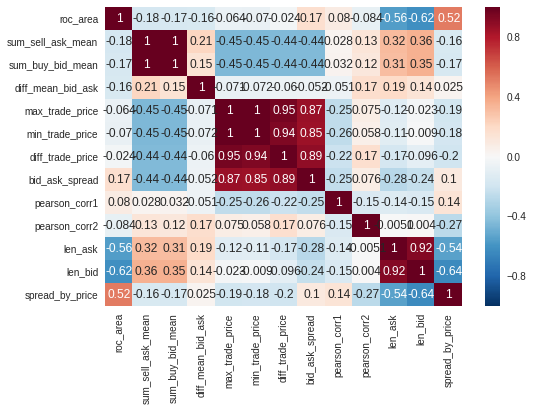

In [7]:
df_summary['spread_by_price'] = df_summary['bid_ask_spread'] / df_summary['diff_trade_price']
sns.heatmap(df_summary.corr(), annot=True)

In [8]:
df_summary[['roc_area', 'diff_mean_bid_ask', 'diff_trade_price', 
            'max_trade_price', 'min_trade_price',
            'spread_by_price']].sort_values(by='spread_by_price')

,roc_area,diff_mean_bid_ask,diff_trade_price,max_trade_price,min_trade_price,spread_by_price
9063,0.541335,524.370832,83.05,510.10,427.05,0.001124
9069,0.548773,1431.670887,61.15,308.00,246.85,0.001629
3161,0.560100,-1236.489997,87.00,419.80,332.80,0.001659
9269,0.546032,-263.420650,60.10,403.05,342.95,0.001743
9086,0.540619,-550.145564,36.10,244.20,208.10,0.001776
5836,0.547025,-28.882488,711.00,3090.00,2379.00,0.001899
9062,0.523169,-17.442632,468.00,3405.00,2937.00,0.002181
9061,0.547274,-451.532183,67.90,730.20,662.30,0.002499
9265,0.546440,-8.307530,396.00,3559.50,3163.50,0.002512
10166,0.556248,10.428470,489.50,3454.50,2965.00,0.002558


In [9]:
df_summary['spread_by_price_diff'] = df_summary['diff_trade_price'] *  df_summary['bid_ask_spread']
df_summary.corr()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid,spread_by_price,spread_by_price_diff
roc_area,1.000000,-0.175810,-0.167597,-0.157103,-0.063800,-0.070457,-0.023669,0.166871,0.079665,-0.084292,-0.555861,-0.616417,0.519940,0.087977
sum_sell_ask_mean,-0.175810,1.000000,0.997950,0.211400,-0.451122,-0.449055,-0.438021,-0.439389,0.028296,0.126480,0.316461,0.357862,-0.163018,-0.341597
sum_buy_bid_mean,-0.167597,0.997950,1.000000,0.148420,-0.451810,-0.449635,-0.439264,-0.441163,0.031992,0.116531,0.307521,0.352974,-0.166589,-0.343823
diff_mean_bid_ask,-0.157103,0.211400,0.148420,1.000000,-0.070747,-0.072020,-0.059899,-0.052038,-0.051347,0.174736,0.193535,0.139116,0.025183,-0.027530
max_trade_price,-0.063800,-0.451122,-0.451810,-0.070747,1.000000,0.998514,0.953902,0.865603,-0.253201,0.075476,-0.120602,-0.022572,-0.188538,0.833952
min_trade_price,-0.070457,-0.449055,-0.449635,-0.072020,0.998514,1.000000,0.936131,0.852827,-0.257259,0.057944,-0.109805,-0.009038,-0.184788,0.815978
diff_trade_price,-0.023669,-0.438021,-0.439264,-0.059899,0.953902,0.936131,1.000000,0.888982,-0.217102,0.167942,-0.173524,-0.095890,-0.198956,0.887681
bid_ask_spread,0.166871,-0.439389,-0.441163,-0.052038,0.865603,0.852827,0.888982,1.000000,-0.245708,0.076429,-0.278915,-0.241781,0.100397,0.942499
pearson_corr1,0.079665,0.028296,0.031992,-0.051347,-0.253201,-0.257259,-0.217102,-0.245708,1.000000,-0.152777,-0.139283,-0.150490,0.136937,-0.173189
pearson_corr2,-0.084292,0.126480,0.116531,0.174736,0.075476,0.057944,0.167942,0.076429,-0.152777,1.000000,-0.005119,0.003971,-0.266781,0.138980


In [10]:
df_by_len = df_summary.sort_values(by='len_bid')
df_by_len.head()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid,spread_by_price,spread_by_price_diff
12417,0.574494,1992.194589,1899.115041,93.079548,323.2,287.8,35.4,0.300025,0.092095,1.197192e-16,617,591,0.008475,10.620879
10484,0.545468,2759.086382,2904.950088,-145.863705,361.1,316.2,44.9,0.289912,0.062488,7.269869e-09,740,682,0.006457,13.017064
4549,0.560937,2303.049247,2488.562896,-185.513649,404.3,352.4,51.9,0.298362,-0.024937,1.701010e-02,692,691,0.005749,15.484992
11869,0.568009,574.881358,607.473504,-32.592146,2806.0,2264.0,542.0,2.093683,0.014033,1.970059e-01,782,704,0.003863,1134.776437
3035,0.583822,6350.159385,5920.926133,429.233252,263.7,235.9,27.8,0.191565,0.044378,3.908516e-05,810,717,0.006891,5.325499


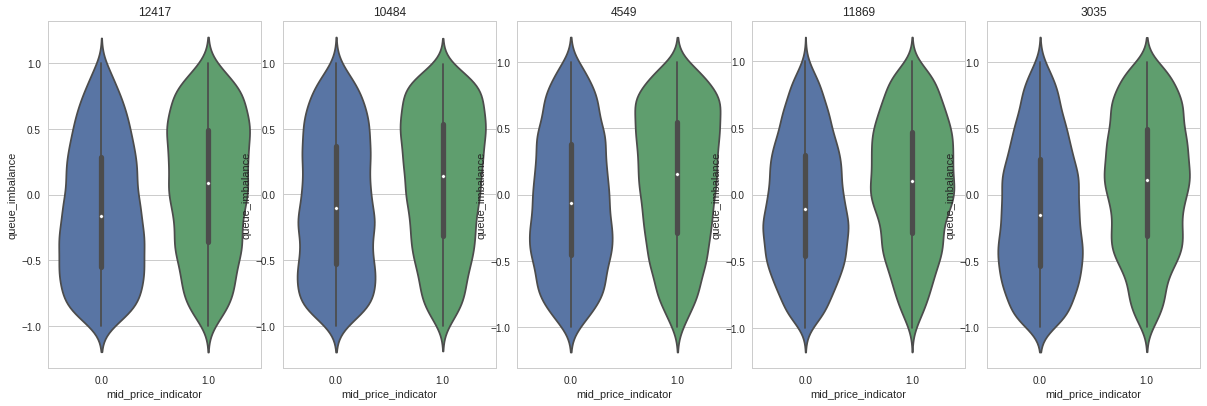

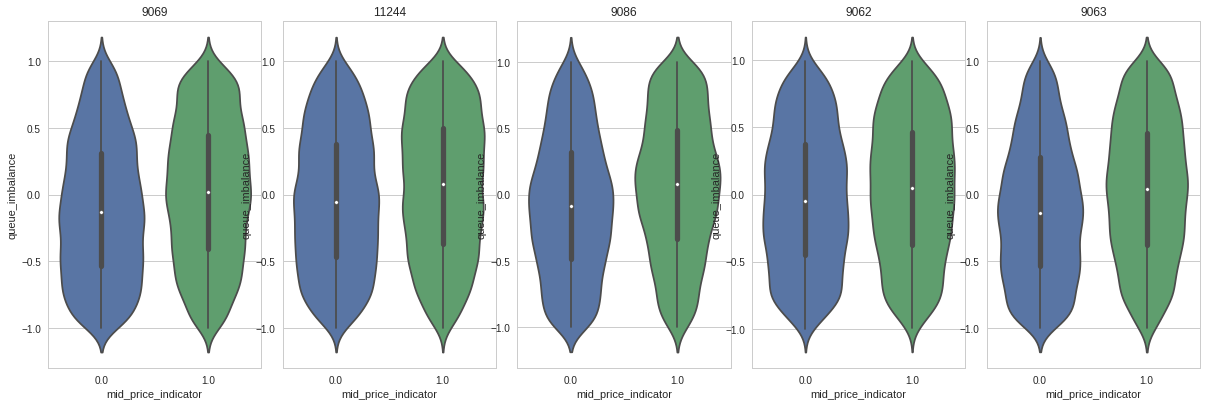

In [11]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

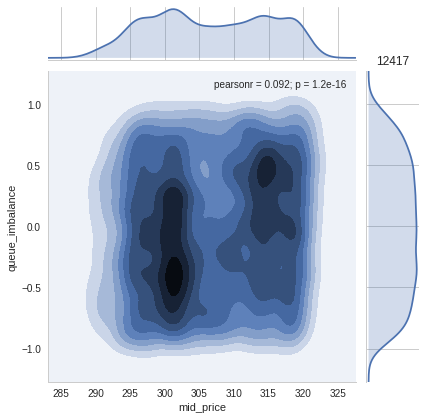

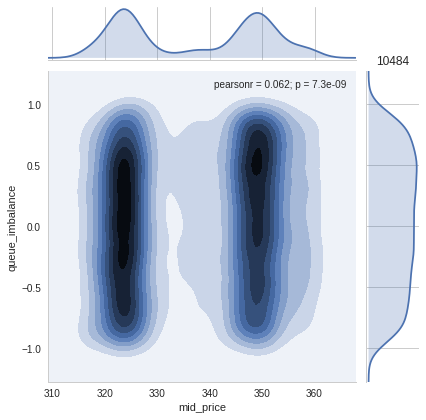

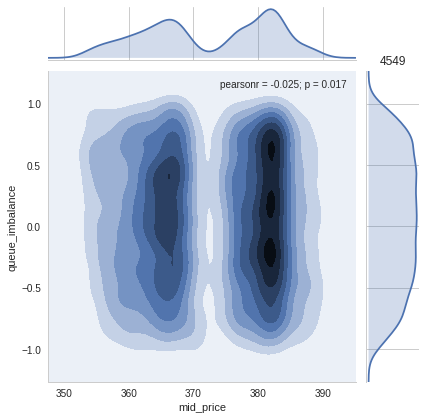

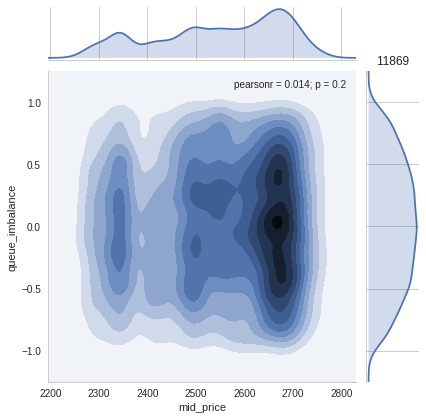

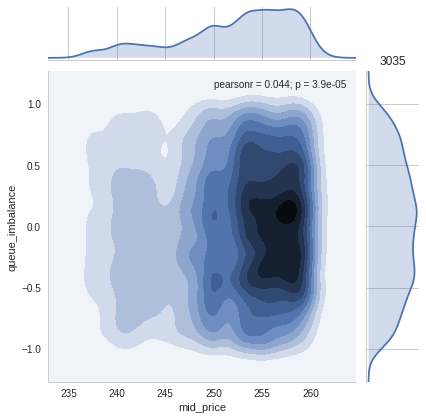

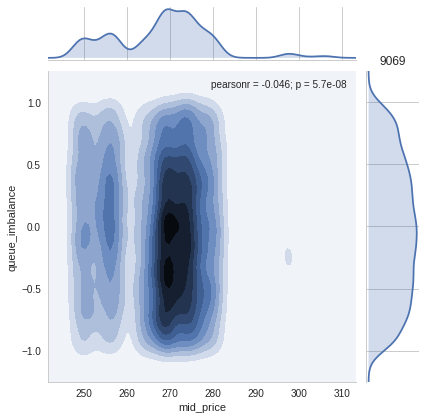

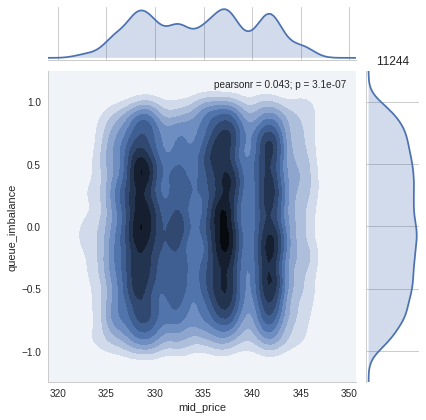

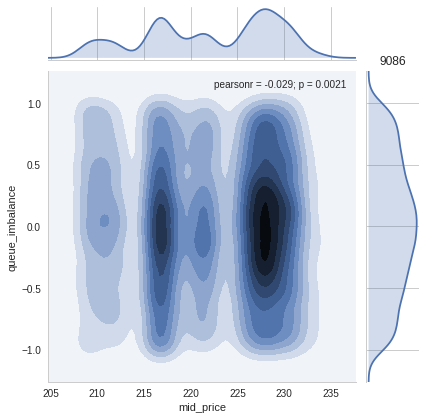

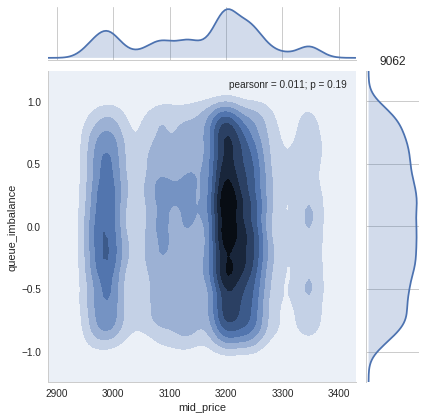

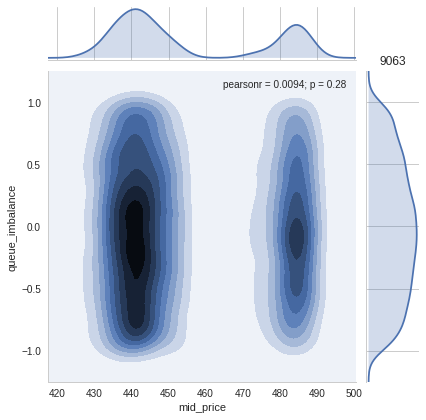

In [12]:
n = 5
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))

plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))
#     sns.jointplot(x="mid_price", y="queue_imbalance", 
#               data=df.loc[:, ['mid_price', 'queue_imbalance']], kind="kde")

Axes(0.125,0.125;0.133621x0.755)
Axes(0.285345,0.125;0.133621x0.755)
Axes(0.44569,0.125;0.133621x0.755)
Axes(0.606034,0.125;0.133621x0.755)
Axes(0.766379,0.125;0.133621x0.755)


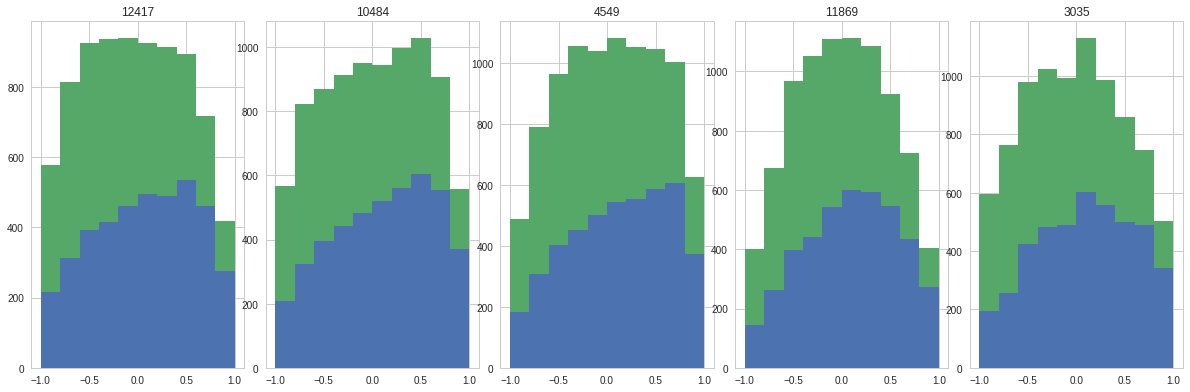

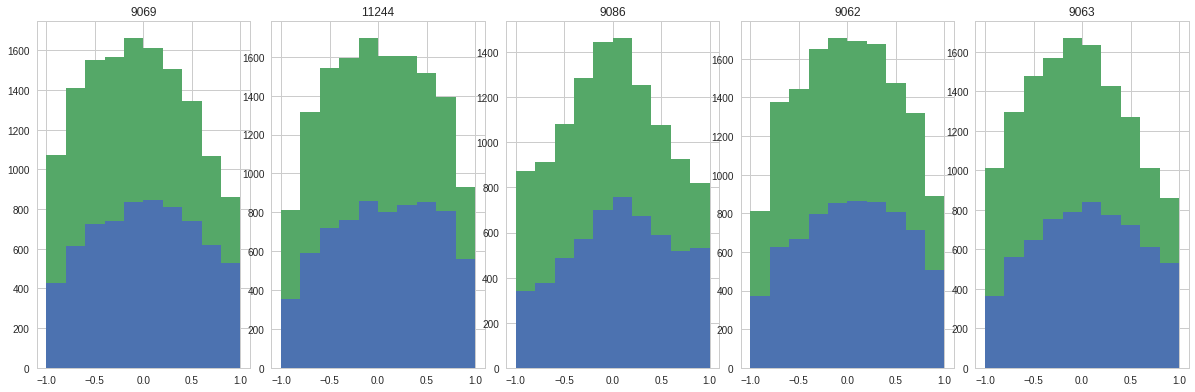

In [13]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    print(axs[i])
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)




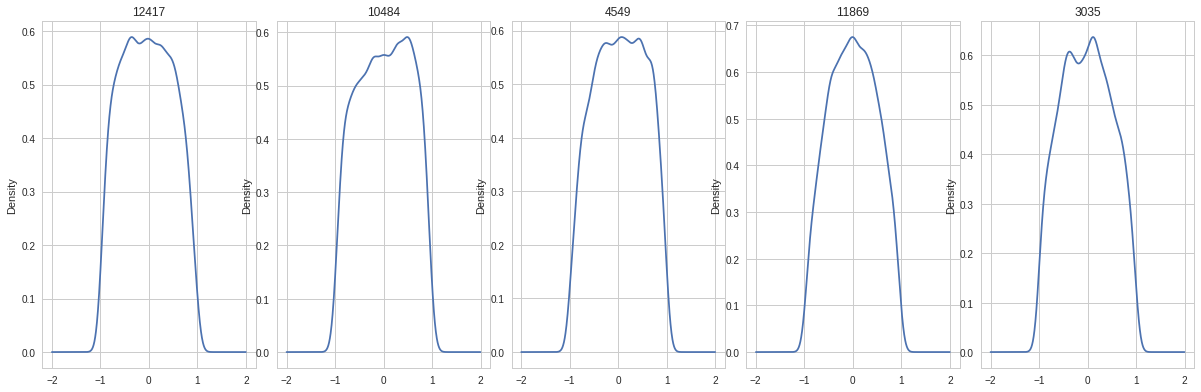

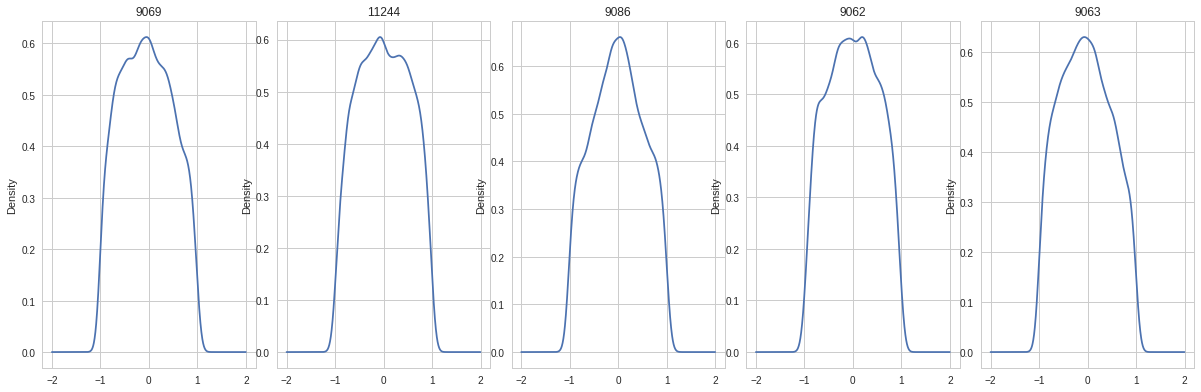

In [14]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

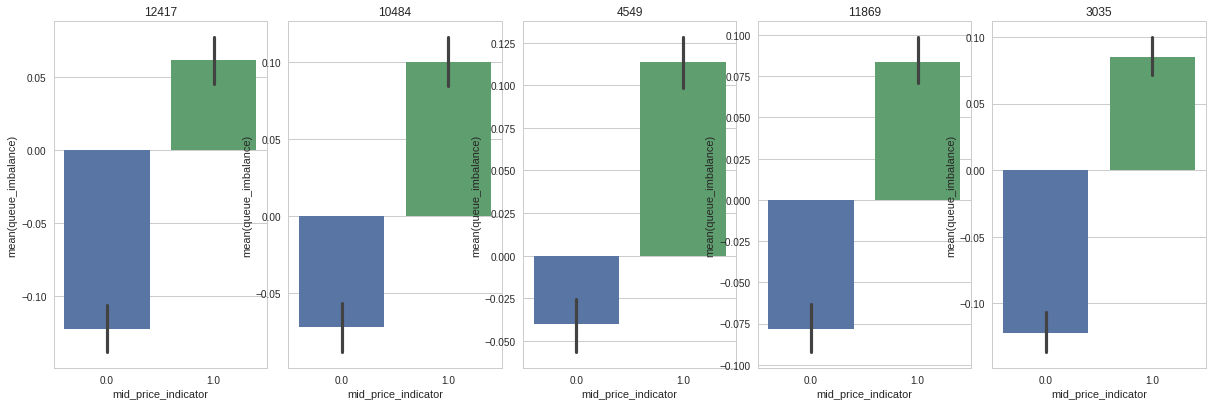

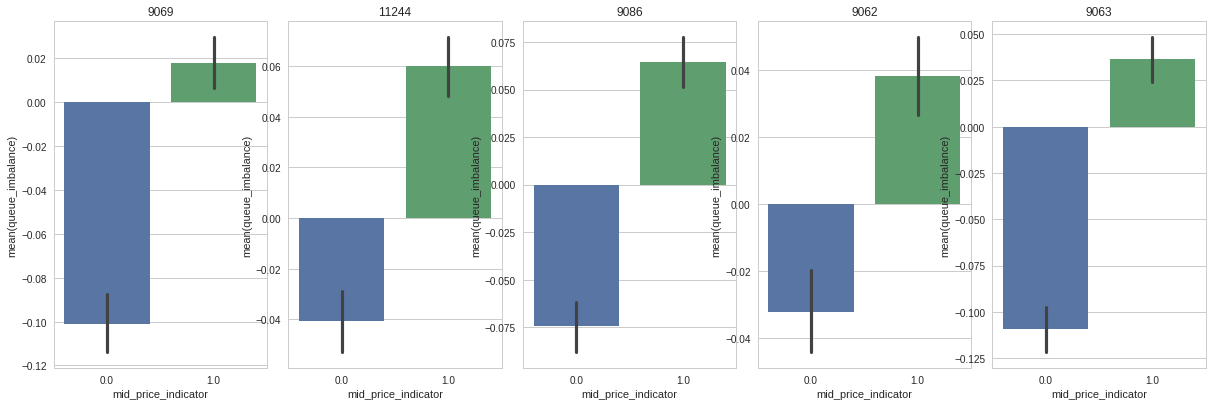

In [15]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

## Clustering data with all features

In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(df_summary)

In [17]:
df_summary['class']= kmeans

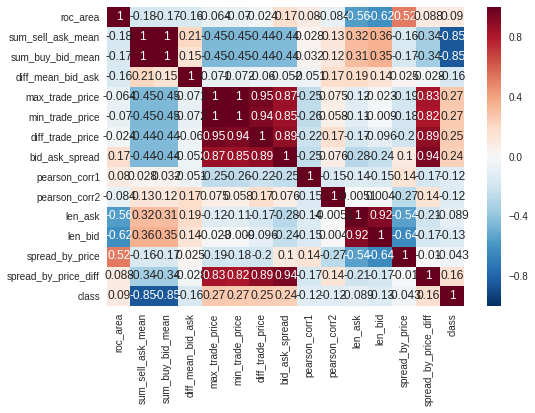

In [18]:
sns.heatmap(df_summary.corr(), annot=True)